In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import json

In [2]:
from tableGAN.utils import create_GAN_data, TabularDataset
from tableGAN.tableGAN import make_noise, CriticNet, WGAN, GeneratorNet

# KDD2009 data

In [3]:
with open('../data/KDD2009.json') as f:
    data = json.load(f)

In [4]:
X_cat = np.array(data['Xcat'])
y = np.array(data['Y']).flatten()

In [5]:
y[y==-1] = 0

In [6]:
single_value_idx = np.where(np.logical_and(np.min(X_cat, axis=0)==0,np.max(X_cat, axis=0)==0))

In [7]:
X_cat = np.delete(X_cat, single_value_idx, axis=1)

In [8]:
X_cat = pd.DataFrame(X_cat)

The tricky part is how to input to the generator the structure of the variables (continuous, binary, multi-class). Additionally, computation is more efficient if all k continuous variables are estimated in one output layer with k output nodes instead of k output layers with 1 output node. 

In [9]:
# Transform binary and multi-level categorical vars to type 'category'
X_cat.iloc[:,0:129] = X_cat.iloc[:,0:129].astype('category', ) 

In [10]:
# Count the number of levels per variable
cat_levels = []
for c in X_cat: #[X.columns[X.dtypes=='category']]:
    if X_cat[c].dtypes == 'float' or X_cat[c].dtypes == 'int':
        cat_levels.append(0)
    elif X_cat[c].dtypes == 'category':
        cat_levels.append(len(X_cat[c].cat.categories))

In [11]:
# re-order the data to continuous, binary, multi-level
#col_order = np.argsort(cat_levels)

#X_cat=X_cat[col_order]
#cat_levels = np.array(cat_levels)[col_order]

In [12]:
cat_levels = np.array(cat_levels)
#X_cat.columns[np.where(cat_levels>2)]

### Pre-processing (scaling, one-hot encoding)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [14]:
class Preprocessor():
    """
    Class to scale and one-hot encode data and undo preprocessing after data generation
    """
    def __init__(self, numeric_features=None, binary_features=None, categorical_features=None):
        self.scaler = StandardScaler()
        self.transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
        
        self.var_order = np.argsort([*numeric_features, *binary_features, *categorical_features])
        self.numeric_org = numeric_features
        self.binary_org = binary_features
        self.categorical_org = categorical_features
        
        self.numeric_new = None
        self.binary_new = None
        self.categorical_new = None
    
    def fit_transform(self, X):
        X_num, X_cat, X_bin = [np.empty(shape = (X.shape[0],)) for i in range(3)]
        i = 0
                                       
        if self.numeric_org is not None: 
            X_num = self.scaler.fit_transform(X[:, self.numeric_org])
            self.numeric_new = list(range(len(self.numeric_org)))
            i += len(self.numeric_org)
        if self.binary_org is not None: 
            X_bin = X[:,self.binary_org]
            self.binary_new = list(range(i, i+len(self.binary_org)))
            i += len(self.binary_org)
        if self.categorical_org is not None: 
            X_cat = self.transformer.fit_transform(X[:, self.categorical_org])
            self.categorical_new = list(range(i, i+X_cat.shape[1]))                                    
            
        return np.hstack([X_num, X_bin, X_cat])
    
    def inverse_transform(self, X):
        X_num, X_cat, X_bin = [np.empty(shape = (X.shape[0],)) for i in range(3)]
                                       
        if self.numeric_new is not None: 
            X_num = self.scaler.inverse_transform(X[:, self.numeric_new])
        if self.binary_new is not None: 
            X_bin = X[:,self.binary_new]
        if self.categorical_new is not None: 
            X_cat = self.transformer.inverse_transform(X[:, self.categorical_new])
        
        X = np.hstack([X_num, X_bin, X_cat])[:,self.var_order]
        
        return X 

In [15]:
numeric_features = np.where(cat_levels==0)[0]
binary_features = np.where(cat_levels==2)[0]
categorical_features = np.where(cat_levels>2)[0]

preproc = Preprocessor(numeric_features, binary_features, categorical_features)

In [16]:
X = preproc.fit_transform(X_cat.values)
print(X.shape)

/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(50000, 300)


In [17]:
# One-hot encode the multi-class variables while keeping all other variables in one column
#X = pd.get_dummies(X_cat, columns=X_cat.columns[np.where(cat_levels>2)])

### Data split

In [18]:
# Split data in train and set set
iSPLIT = data["iSPLIT"][0][0]

X = X.astype("float")
X_cat = X_cat.astype("float")

X_train = X[:iSPLIT,:]
X_test = X[iSPLIT:,:]

X_cat_train = X_cat.iloc[:iSPLIT,:]
X_cat_test = X_cat.iloc[iSPLIT:,:]

y_train = y[:iSPLIT]
y_test = y[iSPLIT:]

# Split off only the miniority data from training set to train WGAN
X_minority = X_train[y_train==1,:]

## Train WGAN

In [19]:
# Input to critic is in the shape of the original data
input_dim=X_train.shape[1]

In [20]:
# Save in a list the 1) number of continuous variables, 2) the number of binary variables, 
# 3) a list with the number of levels for each multi-level categorical
variable_type_counts = [np.sum(cat_levels==0), np.sum(cat_levels==2), cat_levels[cat_levels>2].tolist()]

In [21]:
generator = GeneratorNet(hidden_layers=[512,256], noise_dim=input_dim,
                         n_output_continuous=variable_type_counts[0],
                         n_output_binary=variable_type_counts[1],
                         n_output_categorical=variable_type_counts[2])
#generator = GeneratorNet(noise_dim=100,n_output_continuous=7,n_output_binary=2,n_output_categorical=[3])
critic = CriticNet(input_dim=input_dim, hidden_layers=[256,128], dropout = 0)
wgan = WGAN(generator, critic)

In [22]:
batch_size = 64
#learning_rate = 1e-5
critic_rounds = 5
gradient_penalty_coefficient = 10

In [23]:
X_minority_tab = TabularDataset(X_minority, label=None)
data_loader = DataLoader(X_minority_tab, batch_size=batch_size, shuffle=True)

In [24]:
critic_optimizer = Adam(critic.parameters(), lr=1e-4)
generator_optimizer = Adam(generator.parameters(), lr=1e-4)

In [25]:
num_epochs = 100

In [26]:
critic_performance, generator_performance = wgan.train_WGAN(
    data_loader=data_loader, critic_optimizer=critic_optimizer, generator_optimizer=generator_optimizer,
    num_epochs =num_epochs, gradient_penalty_coefficient= gradient_penalty_coefficient,
    critic_rounds=critic_rounds,
    val_data=torch.from_numpy(X_minority).float()) #torch.from_numpy(X_test).float()

0.030976 | 0.030678
5.964717 | 6.134531
4.488928 | 4.678712
3.264811 | 3.316189
4.439903 | 4.370955
5.116862 | 4.804121
4.836254 | 4.889310
5.252776 | 4.724717
4.289635 | 4.620615
6.120456 | 4.528234
4.199671 | 4.351450
4.384994 | 4.414765
4.338392 | 4.151964
3.845633 | 4.178113
4.222526 | 4.286977
4.040155 | 4.114914
3.884149 | 4.156594
3.867772 | 4.207641
3.603073 | 4.007282
4.457761 | 3.928514
4.354635 | 4.078190
3.607717 | 3.829522
3.553346 | 3.725594
4.215135 | 3.884580
3.708382 | 3.835002
3.555568 | 3.844841
3.636928 | 3.888129
3.842518 | 3.897818
3.919086 | 3.926418
3.999523 | 4.015100
4.083104 | 3.956674
4.265188 | 3.979872
3.894373 | 4.076892
4.063960 | 4.079052
4.056717 | 3.998099
3.897110 | 3.834529
3.758967 | 3.710777
4.253844 | 3.589926
3.790805 | 3.524194
3.431743 | 3.509839
3.575477 | 3.675156
3.677534 | 3.719501
3.603547 | 3.736938
4.050438 | 3.710171
3.428039 | 3.554967
3.290146 | 3.525097
3.353095 | 3.507608
3.395199 | 3.357407
3.715900 | 3.425488
2.809218 | 3.283643


# Synthetic data evaluation

### Distributional distance

In [27]:
fake = pd.DataFrame(wgan.generator.sample(make_noise(20000, dim=wgan.generator.noise_dim)).detach().numpy())

In [28]:
pd.DataFrame(np.vstack([np.round(np.mean(X_minority, axis=0),4), 
                        np.round(np.mean(fake.values, axis=0),4)]))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.0025,-0.0027,-0.0026,0.0057,-0.0216,-0.0705,-0.0001,0.0202,-0.0097,-0.004,...,0.6566,0.0985,0.1559,0.0890,0.9187,0.0547,0.0267,0.5807,0.2291,0.1902
1,0.0441,-0.0092,-0.0321,-0.1136,-0.0238,0.0188,0.0349,0.2405,-0.0800,-0.007,...,0.6537,0.0880,0.1567,0.1016,0.8964,0.0588,0.0448,0.5518,0.2369,0.2113


/Users/hauptjoh/anaconda/envs/deeplearning/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


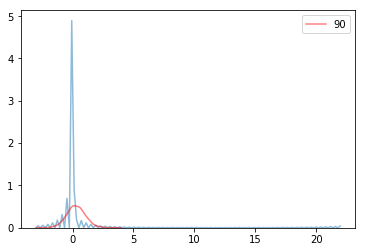

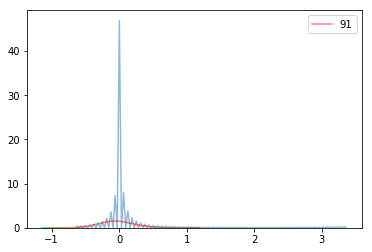

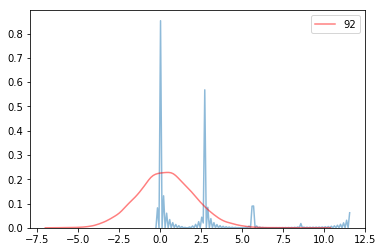

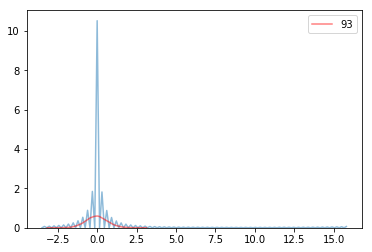

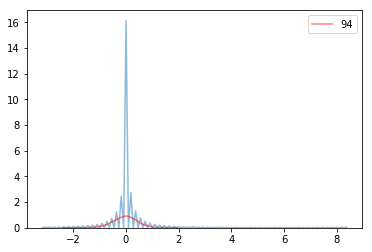

In [29]:
for i in range(90,95):
    sns.kdeplot(X_minority[:,i], alpha=0.5, )
    sns.kdeplot(fake.iloc[:,i], alpha=0.5, color="red")
    plt.show()

### Fake/real prediction

In [30]:
print(np.ones(fake.values.shape[0]).shape)
print(np.zeros(X_minority.shape[0]).shape)

(20000,)
(2213,)


In [31]:
y_fakereal.shape

NameError: name 'y_fakereal' is not defined

In [ ]:
X_fakereal = np.vstack([X_minority, 
                        fake.values])
y_fakereal = np.concatenate([np.zeros(X_minority.shape[0]), 
                        np.ones(fake.values.shape[0])]).flatten()

In [ ]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=100, random_state=123)
model_fakereal = clf.fit(X_fakereal, y_fakereal)

In [ ]:
pred_fakereal = model_fakereal.predict_proba(X_fakereal)[:,1]
roc_auc_score(y_fakereal, pred_fakereal)

In [ ]:
importances = model_fakereal.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_fakereal.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


## Model performance

In [ ]:
np.sum(y_train==1)

In [ ]:
round(np.sum(y_train==1) / np.sum(y_train==0),2)

In [ ]:
pred = {}
model = {}

In [ ]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=100, random_state=123)

model["org"] = clf.fit(X_train, y_train)
pred["org"] = model["org"].predict_proba(X_test)[:,1]

### GANbalance

In [ ]:
balanced_ratio = 0.1

In [ ]:
#n_samples = np.sum(y_train==0) - np.sum(y_train==1)
n_samples = int(np.sum(y_train==0) * balanced_ratio)

In [ ]:
sample = wgan.generator.sample(make_noise(size=n_samples, dim=wgan.generator.noise_dim)).detach().numpy()

In [ ]:
X_train_upsampled = np.vstack([X_train, 
                               sample]
                                )
y_train_upsampled = np.concatenate([y_train, np.ones(n_samples)])

In [ ]:
model["up"] = clf.fit(X_train_upsampled, y_train_upsampled)
pred["up"] = model["up"].predict_proba(X_test)[:,1]

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

In [ ]:
#smote_nc = TomekLinks(sampling_strategy=1, random_state=0, n_jobs=20)
#X_cat_train_smote, y_train_smote = smote_nc.fit_resample(X_cat_train, y_train)

In [ ]:
smote_nc = SMOTENC(sampling_strategy = balanced_ratio, categorical_features=np.where(cat_levels>1)[0], random_state=0, n_jobs=20, )
X_cat_train_smote, y_train_smote = smote_nc.fit_resample(X_cat_train, y_train)

In [ ]:
X_train_smote = pd.DataFrame(X_cat_train_smote)
X_train_smote = pd.get_dummies(X_train_smote, columns=X_train_smote.columns[np.where(cat_levels>2)])

In [ ]:
model["smote"] = clf.fit(X_train_smote, y_train_smote)
pred['smote'] = model["smote"].predict_proba(X_test)[:,1]

### Comparison

In [ ]:
{model:roc_auc_score(y_test, pred[model]) for model in pred}